## Step1 导入相关库

In [1]:
import torch
import numpy as np 
from torch.utils.data import Dataset,DataLoader
import torchvision
from matplotlib import pyplot as plt 
from metrics import Metrics
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils.data import random_split
import os
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from metrics import Metrics

## Step2 数据集处理

In [2]:
#自定义数据集
class CovidDataset(Dataset):
    def __init__(self,images_path,masks_path,transform = None,target_transform = None) -> None:
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.traget_transform = target_transform
        self.images = os.listdir(self.images_path)
    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join(self.images_path,image_name)
        mask_path = os.path.join(self.masks_path,image_name)
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        if self.transform:
            image = self.transform(image)
        if self.traget_transform:
            mask = self.traget_transform(mask)
        return image,mask
    def __len__(self):
        return len(self.images)


In [3]:
image_transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
mask_transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])

In [4]:
# 加载数据集
dataset = CovidDataset('./COVID/images/','./COVID/masks/',image_transform,mask_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


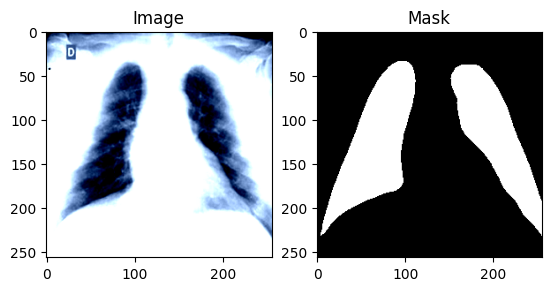

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


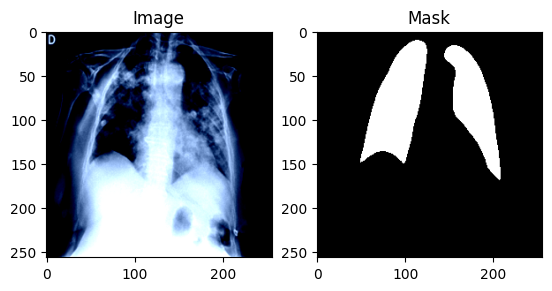

In [5]:
# 可视化
def show_sample(image, mask):
    """显示图像和掩码的函数"""
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.permute(1, 2, 0))  # 图像的通道从[C, H, W]变换到[H, W, C]
    ax[0].set_title("Image")
    ax[1].imshow(mask.permute(1, 2, 0).squeeze(), cmap='gray')  # 对于单通道的掩码，需要squeeze
    ax[1].set_title("Mask")
    plt.show()

# 从数据集中获取一些样本
for i in range(2):
    image, mask = dataset[i]
    print(image.shape)
    show_sample(image, mask)


In [6]:
# 划分训练集和测试集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])
print(len(dataset),len(train_dataset),len(val_dataset))

3616 2892 724


In [7]:
# 读取数据集
train_iter = DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)
val_iter = DataLoader(dataset=val_dataset,batch_size=32,shuffle=True)

## Step3 模型搭建

In [8]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()  
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),  
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()  
        self.max_pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.max_pool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()  
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
            x1 = self.up(x1)
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
            x = torch.cat([x2, x1], dim=1)
            return self.conv(x)
class OutConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=1)
    def forward(self,x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


## Step4 模型设置

In [9]:
net = UNet(3,2)
loss = nn.CrossEntropyLoss()
num_classes = 2
optimizer = torch.optim.SGD(net.parameters(),lr=1e-3,weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

## Step5 模型训练

In [10]:
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path='best_model.pth'):
    model.to(device)
    me = Metrics(2)
    best_acc = 0.0  # 初始化最高精度为0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            labels = torch.squeeze(labels, 1)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Ensure preds and labels are on CPU before calling addbatch
            preds_cpu = preds.cpu()
            labels_cpu = labels.cpu()
            me.addbatch(preds_cpu, labels_cpu)  # Modified line

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = me.mIou()

        print(f'Epoch {epoch}/{num_epochs - 1} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        me.reset()

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()
                labels = torch.squeeze(labels, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                # Ensure preds and labels are on CPU before calling addbatch
                preds_cpu = preds.cpu()
                labels_cpu = labels.cpu()
                me.addbatch(preds_cpu, labels_cpu)  # Modified line

                val_loss += loss.item() * inputs.size(0)

            val_epoch_loss = val_loss / len(val_loader.dataset)
            val_epoch_acc = me.mIou()

            print(f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')

            # Check if this is the best model so far
            if val_epoch_acc > best_acc:
                best_acc = val_epoch_acc
                torch.save(model.state_dict(), save_path)
                print(f"New best model with val accuracy: {best_acc:.4f} saved to {save_path}")

            me.reset()

    return model


In [11]:
train_model(net, train_iter, val_iter, loss, optimizer, num_epochs=25,device=device,save_path='./best.pt')


100%|██████████| 46/46 [00:32<00:00,  1.43it/s]


Epoch 0/24 - Loss: 0.5586 Acc: 0.5303
Val Loss: 0.5160 Val Acc: 0.5911
New best model with val accuracy: 0.5911 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.48it/s]


Epoch 1/24 - Loss: 0.4540 Acc: 0.6490
Val Loss: 0.4171 Val Acc: 0.6942
New best model with val accuracy: 0.6942 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 2/24 - Loss: 0.3794 Acc: 0.7429
Val Loss: 0.3473 Val Acc: 0.7736
New best model with val accuracy: 0.7736 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 3/24 - Loss: 0.3192 Acc: 0.8015
Val Loss: 0.2984 Val Acc: 0.8138
New best model with val accuracy: 0.8138 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 4/24 - Loss: 0.2763 Acc: 0.8317
Val Loss: 0.2604 Val Acc: 0.8373
New best model with val accuracy: 0.8373 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 5/24 - Loss: 0.2452 Acc: 0.8490
Val Loss: 0.2342 Val Acc: 0.8525
New best model with val accuracy: 0.8525 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 6/24 - Loss: 0.2217 Acc: 0.8604
Val Loss: 0.2196 Val Acc: 0.8580
New best model with val accuracy: 0.8580 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 7/24 - Loss: 0.2039 Acc: 0.8684
Val Loss: 0.1975 Val Acc: 0.8697
New best model with val accuracy: 0.8697 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 8/24 - Loss: 0.1891 Acc: 0.8756
Val Loss: 0.1834 Val Acc: 0.8747
New best model with val accuracy: 0.8747 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 9/24 - Loss: 0.1776 Acc: 0.8810
Val Loss: 0.1739 Val Acc: 0.8810
New best model with val accuracy: 0.8810 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 10/24 - Loss: 0.1676 Acc: 0.8865
Val Loss: 0.1643 Val Acc: 0.8857
New best model with val accuracy: 0.8857 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 11/24 - Loss: 0.1595 Acc: 0.8904
Val Loss: 0.1577 Val Acc: 0.8895
New best model with val accuracy: 0.8895 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 12/24 - Loss: 0.1520 Acc: 0.8946
Val Loss: 0.1517 Val Acc: 0.8929
New best model with val accuracy: 0.8929 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 13/24 - Loss: 0.1459 Acc: 0.8975
Val Loss: 0.1470 Val Acc: 0.8936
New best model with val accuracy: 0.8936 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 14/24 - Loss: 0.1402 Acc: 0.9006
Val Loss: 0.1403 Val Acc: 0.8988
New best model with val accuracy: 0.8988 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 15/24 - Loss: 0.1353 Acc: 0.9030
Val Loss: 0.1353 Val Acc: 0.9011
New best model with val accuracy: 0.9011 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 16/24 - Loss: 0.1305 Acc: 0.9060
Val Loss: 0.1306 Val Acc: 0.9032
New best model with val accuracy: 0.9032 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 17/24 - Loss: 0.1267 Acc: 0.9078
Val Loss: 0.1267 Val Acc: 0.9051
New best model with val accuracy: 0.9051 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 18/24 - Loss: 0.1228 Acc: 0.9102
Val Loss: 0.1250 Val Acc: 0.9066
New best model with val accuracy: 0.9066 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 19/24 - Loss: 0.1190 Acc: 0.9126
Val Loss: 0.1216 Val Acc: 0.9081
New best model with val accuracy: 0.9081 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


Epoch 20/24 - Loss: 0.1158 Acc: 0.9144
Val Loss: 0.1184 Val Acc: 0.9108
New best model with val accuracy: 0.9108 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 21/24 - Loss: 0.1132 Acc: 0.9157
Val Loss: 0.1160 Val Acc: 0.9108


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 22/24 - Loss: 0.1104 Acc: 0.9175
Val Loss: 0.1160 Val Acc: 0.9109
New best model with val accuracy: 0.9109 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 23/24 - Loss: 0.1080 Acc: 0.9187
Val Loss: 0.1107 Val Acc: 0.9135
New best model with val accuracy: 0.9135 saved to ./best.pt


100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


Epoch 24/24 - Loss: 0.1053 Acc: 0.9205
Val Loss: 0.1090 Val Acc: 0.9155
New best model with val accuracy: 0.9155 saved to ./best.pt


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (max_pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momen

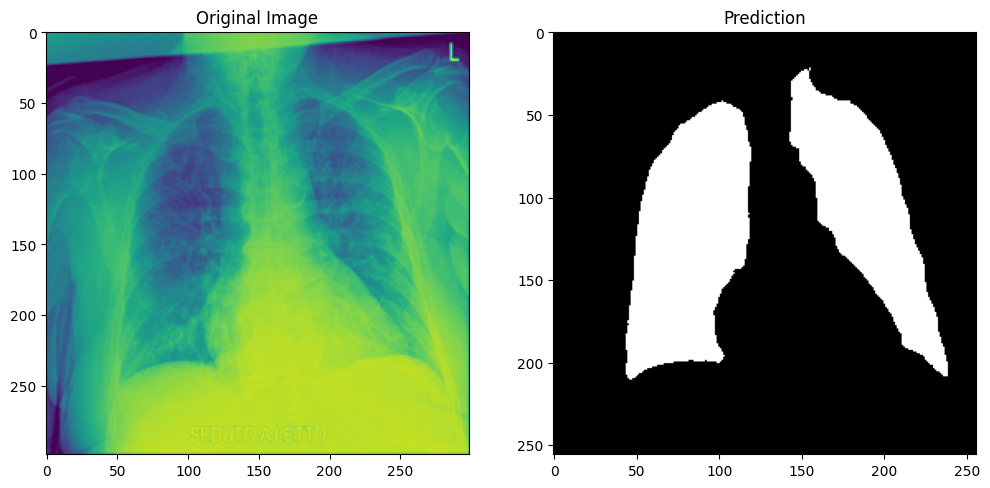

In [12]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_image(image_path, transform=None):
    """ 加载并预处理图像 """
    image = Image.open(image_path).convert('RGB')
    if transform is not None:
        image = transform(image)
    return image

def predict_image(model, image, device):
    """ 对单个图像进行推理 """
    image = image.unsqueeze(0)  # 增加一个批次维度
    image = image.to(device)

    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        outputs = model(image)
        preds = torch.argmax(outputs, 1)  # 获取最可能的预测结果
    return preds

def visualize_prediction(image, prediction):
    """ 可视化预测结果 """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title("Prediction")
    plt.imshow(prediction, cmap='gray')

    plt.show()


# 加载模型

# 推理单个图像
image_path = './COVID/images/COVID-7.png'
image = load_image(image_path, image_transform)
prediction = predict_image(net, image, device)
prediction = prediction.cpu().squeeze(0).numpy()  # 转换为 NumPy 数组

# 可视化原始图像和预测结果
original_image = Image.open(image_path)  # 加载原始图像进行可视化
visualize_prediction(original_image, prediction)
